In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
df=pd.read_csv('targets.csv')
df['npv'] = df.apply(axis=1, func=lambda x : np.npv(0.07, [0, x.oneYearTarget,0,x.threeYearTarget])/2)
ohlc = yf.download(df.ticker.to_list(), period="max")
prices=ohlc["Adj Close"]
prices=prices.dropna()

df['price'] = df.apply(axis=1, func=lambda x : prices[x.ticker].iloc[-1])

df['upside'] = (df.npv - df.price)/df.price

df


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).
  


[*********************100%***********************]  19 of 19 completed


,ticker,amount,oneYearTarget,threeYearTarget,npv,price,upside
0,RUAL.ME,84450,40.000,60.000,43.180525,30.100000,0.434569
1,RASP.ME,30000,150.000,200.000,151.723246,112.820000,0.344826
2,SBER.ME,10000,280.000,400.000,294.100697,226.809998,0.296683
3,QIWI.ME,0,1600.000,2000.000,1563.961428,1495.500000,0.045778
4,HYDR.ME,1050000,1.000,1.200,0.957068,0.752100,0.272528
5,OGKB.ME,0,0.850,1.000,0.805345,0.751900,0.071080
6,ROSN.ME,0,400.000,450.000,370.582910,366.750000,0.010451
7,GAZP.ME,8300,250.000,350.000,259.674558,187.130005,0.387669
8,MGNT.ME,100,5500.000,6500.000,5223.061558,4612.000000,0.132494
9,ALRS.ME,12000,90.000,120.000,91.033947,68.900002,0.321247


In [3]:
mcaps = {}
for t in df.ticker.to_list():
    try:
        stock = yf.Ticker(t)
        info=stock.info
        mcaps[t] = info["sharesOutstanding"]*info['regularMarketPrice']                
    except: 
        print(f'failed for {t}')


failed for HYDR.ME
failed for GAZP.ME


In [4]:
mcaps['GAZP.ME']=4430000000000
mcaps['HYDR.ME']=321000000000

## Constructing the prior

In [5]:
import pypfopt
pypfopt.__version__

'1.2.4'

In [6]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = 1.0


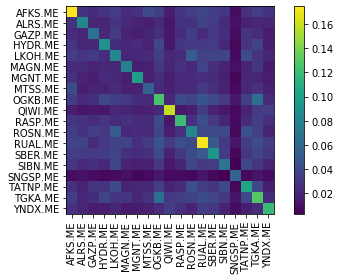

In [7]:
plotting.plot_covariance(S);

In [8]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

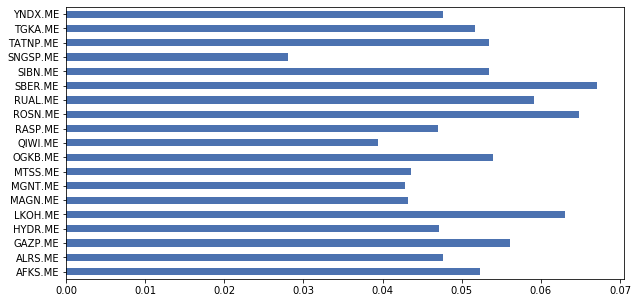

In [9]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [10]:
viewdict = df.set_index('ticker')['upside'].to_dict()
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

In [11]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()

We can visualise how this compares to the prior and our views:

In [12]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AFKS.ME,0.052281,0.154366,0.122874
ALRS.ME,0.047586,0.231249,0.321247
GAZP.ME,0.056047,0.245836,0.387669
HYDR.ME,0.047081,0.194821,0.272528
LKOH.ME,0.063067,0.178898,0.192090
MAGN.ME,0.043210,0.160969,0.162956
MGNT.ME,0.042817,0.130914,0.132494
MTSS.ME,0.043541,0.154020,0.182848
OGKB.ME,0.054007,0.142256,0.071080
QIWI.ME,0.039457,0.073104,0.045778


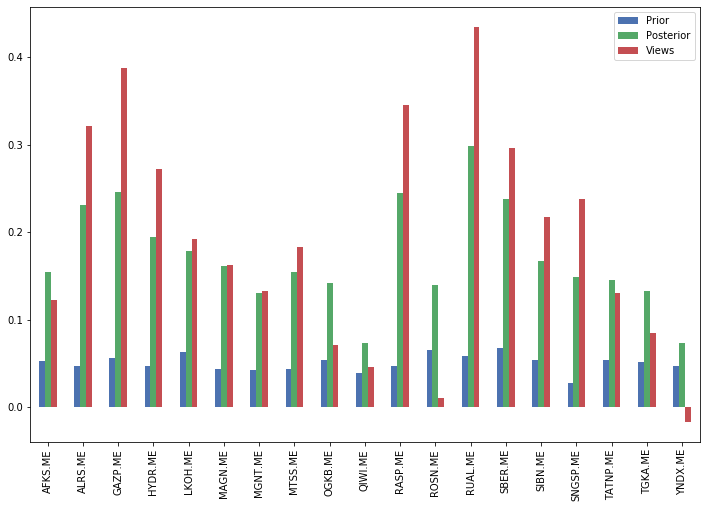

In [13]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is always between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

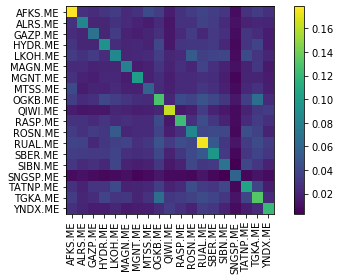

In [14]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimisers discussed in previous recipes.

In [15]:
from pypfopt import EfficientFrontier, objective_functions

In [16]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()


/opt/conda/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:182: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


OrderedDict([('AFKS.ME', 0.03816),
             ('ALRS.ME', 0.08576),
             ('GAZP.ME', 0.09561),
             ('HYDR.ME', 0.06576),
             ('LKOH.ME', 0.0541),
             ('MAGN.ME', 0.05052),
             ('MGNT.ME', 0.03685),
             ('MTSS.ME', 0.04908),
             ('OGKB.ME', 0.02992),
             ('QIWI.ME', 0.0092),
             ('RASP.ME', 0.08678),
             ('ROSN.ME', 0.03161),
             ('RUAL.ME', 0.10292),
             ('SBER.ME', 0.0814),
             ('SIBN.ME', 0.05252),
             ('SNGSP.ME', 0.05906),
             ('TATNP.ME', 0.03753),
             ('TGKA.ME', 0.02674),
             ('YNDX.ME', 0.00646)])

In [22]:
usdrub=yf.download('RUB=X', period="1d").Close.iloc[0]

[*********************100%***********************]  1 of 1 completed


73.40299987792969

In [28]:
stocksCap=df.apply(axis=1, func=lambda x :  x.price*x.amount).sum()
rubCash=401000+252000 + 419000
usdCash=4083+15866
totalCash=rubCash+usdCash*usdrub
totalCap=stocksCap + totalCash

stocksExposurePct=0.8

targetStocksExposure=stocksExposurePct*totalCap

pd.Series({'Total Cap (k)' : totalCap/1000, 
           'Total Cash (k)' : totalCash/1000, 
           'Stocks %' : stocksCap/totalCap*100,
           'Target Stock Exp (k)' : targetStocksExposure/1000,
          }
         )



Total Cap (k)          15507.89
Total Cash (k)          2536.32
Stocks %                  83.64
Target Stock Exp (k)   12406.31
dtype: float64

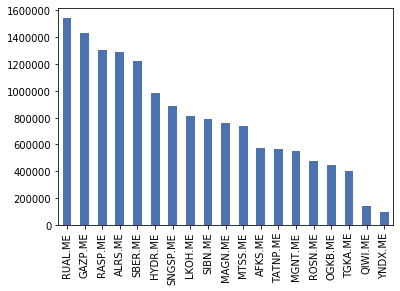

In [17]:
(pd.Series(weights)*targetStocksExposure).sort_values(ascending=False).plot.bar()

In [32]:
targetMoney=pd.Series(weights)*targetStocksExposure

df['adjust-needed-k']=df.apply(axis=1, func=lambda x :  int(targetMoney[x.ticker] - x.price*x.amount)/1000 )

df['cap-k']=df.apply(axis=1, func=lambda x :  (x.price*x.amount)/1000 )

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df[['ticker', 'cap-k','adjust-needed-k']]


,ticker,cap-k,adjust-needed-k
0,RUAL.ME,2541.95,-1265.09
1,RASP.ME,3384.60,-2307.98
2,SBER.ME,2268.10,-1258.23
3,QIWI.ME,0.00,114.14
4,HYDR.ME,789.70,26.13
5,OGKB.ME,0.00,371.20
6,ROSN.ME,0.00,392.16
7,GAZP.ME,1553.18,-367.01
8,MGNT.ME,461.20,-4.03
9,ALRS.ME,826.80,237.16
